In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from glob import glob

In [3]:
plt.rcParams.update({'font.size': 8})
plt.style.use('seaborn-v0_8-darkgrid')

### Contents

1. [Intro](#intro)
    * 1.1 [Basic risk factors mapping](#basic-risk-factors-mapping)
    * 1.2 [Basic model](#basic-model)
    * 1.3 [Brief aside on notation](#brief-aside-on-notation)
2. [Demonstration: real stock data](#demonstration-real-stock-data)
    * 2.1 [Data wrangling](#data-wrangling)
    * 2.2 [Implementation](#implementation)
    * 2.3 [Start](#start)
    * 2.4 [Plots](#plots)
    * 2.5 [Checking against theory](#checking-against-theory)
    * 2.6 [Back to risks](#back-to-risks)
    * 2.7 [VAR](#var)
3. [Conclusion: does it all make sense?](#conclusion-does-it-all-make-sense)
4. [Sources](#sources)

#### Intro
The goal is to assess risks for our balance sheet. Risks are numerous. Basel accords represent an effort to establish international regulatory standards regarding financial risk management. Basel's emphasis is on counterparty credit risk, but there are many more, including operational risks, liquidity risks, etc.  

#### Basic risk factors mapping
[[To the top]](#contents)

(General discussion of risk factors henceforth follows [2])

Here I deal only with the risk of price changes of assets $S\in \mathbb{R}^m$ in our portfolio.  
Suppose asset allocation $\xi \in \mathbb{R}^m$ is fixed, then our value function at time $t$ looks this way:    
$V(t) = \xi^T S_t$  
  
Loss $L(t)$ at time $t+\Delta t$:  
  
$L(t+\Delta t) = V(t+\Delta t) - V(t)$  
  
If $V(t)$ is differentiable, we may use first- or second-order Taylor expansion:  
  
$L(t+\Delta t) \approx \frac{dV(t)}{dt} \Delta t + \frac{dV^2(t)}{dt^2} \frac{(\Delta t)^2}{2}$  

#### Basic model
[[To the top]](#contents)

As example I take exponentially weighted moving average (EWMA) model, proposed by RiskMetrics group in 1996.  
They model asset prices as geometric Brownian motion with drift assumed to be zero:

$\frac{dP_t}{P_t} = \mu dt + \sigma dW_t$  

Why zero drift? ([1] p14) 
>In fact, most forecasts are not even likely to predict the sign of returns for a horizon shorter than three months. In addition, since volatility is much larger than the expected return at short horizons, the forecasts of future distribution of returns are dominated by the volatility estimate σ . In other words, when we are dealing with short horizons, using a zero expected return assumption is as good as any mean estimate one could provide, except that we do not have to worry about producing a number for μ.  
  
---  

#### Brief aside on notation
They denote absolute price levels with capitals $P_t$, log-prices with small $p_t=log P_t$, returns with small $r_t = log(P_t) - log(P_{t-1}) = log(\frac{P_t}{P_{t-1}})$. Log-prices are modelled as normal, hence absolute prices would behave log-normally.  

---
  
With drift, being zero, we only have to estimate standard deviation. For that they propose EWMA:  
  
$\sigma^2_{t+1|t} = \lambda \sigma^2_{t|t-1} + (1-\lambda)r^2_t$  
  
where $\sigma^2_{t|t-1}$ is our sigma estimate at the previous timestep $t$,  
  
$r_t=log\frac{P_t}{P_{t-1}}$ is log return, 
  
and $\lambda$ is *decay* factor, governing how much influence recent observations have. They suggest values 0.94 and 0.97 ([1] p15):  

>The conclusion of the discussion in RiskMetrics Classic is that on average λ = 0.94 produces a very good forecast of one-day volatility, and λ = 0.97 results in good estimates for one-month volatility.

Above is a recursive form, which of course could be expanded into longer sum with squared log returns weighted exponentially in time.  

For a multivariate case (a bunch of time series) we also have to estimate covariances:  
  
$\sigma^2_{(i,j), t+1|t} = \lambda \sigma^2_{(i,j), t|t-1} + (1-\lambda)r_{(i),t}r_{(j),t}$  

How many past values to use in EWMA ([1] p15)?  
  
>An important consequence of using an exponential weighting scheme is that regardless of the actual number of historical returns used in the volatility calculation, the effective number of days used is limited by the size of the decay factor. In other words, 99.9% of the information is contained in the last log(0.001)/ log(λ) days. For example, if we use λ = 0.94, then 99.9% of the information is contained in the last 112 days. For λ = 0.97, 99.9% of the information is contained in the last 227 days.

They do not elaborate on this log fraction formula, but clearly it's just a portion of total area under decay curve.  
Total area:  
  
$S(\inf) = \int^{\inf}_{0}\lambda^xdx = \frac{\lambda^x}{ln \lambda} \rvert^{\inf}_{0} = -\frac{1}{ln \lambda}$  

Area up to $a$:  
  
$S(a) = \int^{a}_{0}\lambda^xdx = \frac{\lambda^a-1}{ln \lambda}$  
  
Then $\alpha$%-area should satisfy  
  
$\frac{S(x)}{S(\inf)}=\alpha$  
  
which yields  
  
$x=log_{\lambda}\alpha = \frac{ln \alpha}{ln \lambda}$  

So it's not about information theory or smth, just decay grows fast and past observations cease to matter numerically at some point.  


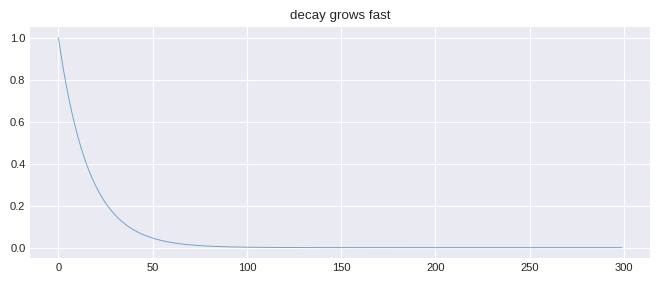

In [4]:
fig,ax=plt.subplots(figsize=(8,3))
ax.plot(0.94**np.arange(300), lw=0.7, alpha=0.6);
ax.set_title('decay grows fast');

#### Demonstration: real stock data
[[To the top]](#contents)

#### Data Wrangling

Let's pick three stocks for our toy portfolio - GAZP, SBER, CHMF, get historical daily prices for the past 10 years. Historical prices are available, eg at https://www.finam.ru/quote/moex/gazp/export/  

We'll apply EWMA to model future price variation.

In [20]:
def preproc(path: str) -> pd.DataFrame:
    """
    Reads csv from the `path`, performs basic preprocessing and returns
    DaraFrame of closing prices 
    """
    df = pd.read_csv(path)
    ticker = df['<TICKER>'].iloc[0]
    return ( df
            .rename(columns=lambda s: s.lower()[1:-1])
            .pipe(lambda df: df.assign(dtime = ( pd.to_datetime(df['date']
                                               .map(str)
                                               .map(lambda x: f'20{x[:2]}-{x[2:4]}-{x[4:6]}')))))
            .set_index('dtime')
            .loc[:,['close']]
            .rename(columns=lambda s: f'{s}_{ticker}')
    )

In [5]:
paths = glob('/media/forveg/battleground/Downloads/stocks/*.txt')
# proceed sequentially in case there are too many files
df = reduce(lambda acc,x: pd.concat([acc, preproc(x)], axis=1), paths[1:], preproc(paths[0]))

In [7]:
df.isna().sum()

close_GAZP    0
close_SBER    0
close_CHMF    0
dtype: int64

In [8]:
x = df.values

In [9]:
r = np.log(x[1:]) - np.log(x[:-1])

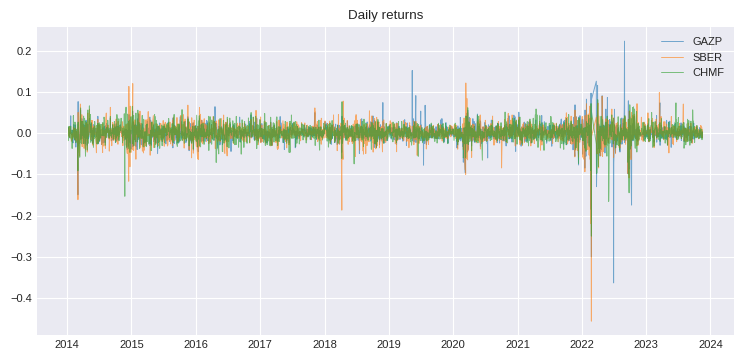

In [18]:
fig,ax=plt.subplots(figsize=(9,4))
ax.plot(df.index[1:], r, lw=0.7, alpha=0.6)
ax.set_title('Daily returns');
ax.legend(['GAZP', 'SBER', 'CHMF']);

#### Implementation
[[To the top]](#contents)

  
EWMA formulas, stated above, are for estimation of covariance single step ahead. For multi-step prediction they derive this concise relation:  
$\sigma^2_{t+T|t}=T \sigma^2_{t+1|t}$  

meaning that variance estimate is constant for future *individual* timesteps, but those timesteps add up (because it's a random walk) so we get overall linear scaling. 

Implementation below follows the formulas, but for multi-step prediction I also did recursive forecasts:  
1. predict $\sigma_{t+1|t}$ using past $T$ sigma values
2. predict $\sigma_{t+k|t}$ using past $T$ sigma values, *incuding the last $k$ estimates*
3. repeat until we get to $t+horiz$

It's an ordinary recursive strategy, used in time series forecasts and associated with accumulation of error, because we built etimate upon estimate. It's not mentioned in the report, but let's see how close it agrees with linear covariance scaling

In [44]:
def cov_predict(x: np.ndarray, T: int, decay: float, horiz: int) -> np.ndarray:
    """
    Estimates covariance matrices [1..horiz] steps ahead.
    Parameters
    ----------
    x : np.ndarray (sz, dim)
        Array of absoulte prices *up to the point we forecast from*.
        Typically a subarray of the whole timeseries.
    T : int
        Number of past observations, used by EWMA
    decay : float (0, 1)
        Decay factor. Recommended values are 0.94 for daily and 0.97 for monthly forecasts
    horiz : int
        Number of steps to predict

    Returns
    -------
    covs : np.ndarray (horiz, dim, dim)
        Array of covariance matrices for steps t+1..t+horiz,
        where t is the last observation of `x`
    """
    
    sz, dim = x.shape
    T = min([T, sz])
    sz-=1
    r = np.log(x[1:]) - np.log(x[:-1])
    w = decay**np.arange(T)[::-1][:,None,None]
    cov = np.array([ np.outer(r[i],r[i]) for i in range(sz-T, sz)])
    
    for i in range(horiz):
        cov_t = (1-decay)*np.sum(cov*w, axis=0)
        cov = np.concatenate([cov[1:], cov_t[None,...]],axis=0)
    return cov[-horiz:]

In [256]:
decay=0.94
(1-decay)/(1-decay**T), (1-decay)

(0.06000000052060385, 0.06000000000000005)

In [22]:
def sample_trajectory(p0: np.ndarray, covs: np.ndarray, n_paths=100) -> np.ndarray:
    """
    p0 : np.ndarray (dim,) 
        Initial absolute price (last known)
    covs : np.ndarray (horiz, dim, dim)
        Array of covariance matrices, each corresponding to a future timestep
    """
    assert covs.shape[1]==covs.shape[2] and covs.shape[1]==p0.shape[0], 'shape mismatch'
    zs = np.random.randn(*covs.shape[:2], n_paths)
    eival, eivect = np.linalg.eig(covs)
    c = np.array([eivec @ np.diag(np.sqrt(eiv)) @ z for eiv,eivec,z in zip(eival, eivect, zs)])
    p0 = np.log(p0)[None,:,None]
    return p0 + np.cumsum(c,axis=0)

In [45]:
def cov_predict_recursive(x, T, decay):
    """
    Estimates covariance matrix single timestep into future.
    Parameters
    ----------
    x : np.ndarray (sz, dim)
        Array of absoulte prices *up to the point we forecast from*.
        Typically a subarray of the whole timeseries.
    T : int
        Number of past observations, used by EWMA
    decay : float (0, 1)
        Decay factor. Recommended values are 0.94 for daily and 0.97 for monthly forecasts

    Returns
    -------
    cov : np.ndarray (dim, dim)
        Covariance for the next timestep
    """
    sz, dim = x.shape
    T = min([T, sz])
    r = np.log(x[1:]) - np.log(x[:-1])
    sz-=1
    w = decay**np.arange(T)[::-1][:,None,None]
    cov = np.zeros((T, dim, dim))
    cov[0] = np.outer(r[sz-T],r[sz-T])
    for i in range(1,T):
        cov[i] = decay*cov[i-1] + (1-decay)*np.outer(r[sz-T+i],r[sz-T+i])
    
    return cov[-1]

In [99]:
def cov_predict_analytical(x: np.ndarray, T: int, decay: float, horiz: int) -> np.ndarray:
    """
    Estimates covariance matrices [1..horiz] steps ahead.
    Parameters
    ----------
    x : np.ndarray (sz, dim)
        Array of absoulte prices *up to the point we forecast from*.
        Typically a subarray of the whole timeseries.
    T : int
        Number of past observations, used by EWMA
    decay : float (0, 1)
        Decay factor. Recommended values are 0.94 for daily and 0.97 for monthly forecasts
    horiz : int
        Number of steps to predict

    Returns
    -------
    covs : np.ndarray (horiz, dim, dim)
        Array of covariance matrices for steps t+1..t+horiz,
        where t is the last observation of `x`
    """
    
    cov = cov_predict(x, T, decay, 1) 
    return np.arange(1,horiz+1)[:,None,None] * cov

#### Start

[[To the top]](#contents)

In [47]:
horiz    = 100
T        = 300
train_sz = 1500
decay    = 0.94

As a brief implementation sanity check* recursive and non-recursive methods have to yield close enough estimates

*unless both routines are wrong in the same way or differ due to numerical issues

In [49]:
for i in range(200):
    cov1 = cov_predict(x[:train_sz-i], T, decay, 1)
    cov2 = cov_predict_recursive(x[:train_sz-i], T, decay)
    assert np.allclose(cov1, cov2, rtol=0, atol=1e-6)
print('sounds good')

sounds good


Let's say the last known price is $p_t$. To sample a future price trajectory I predict covariances $\Sigma_{t+k}, k\in[1,100]$, then simulate price $p_{t+k} = p_{t+k-1} + DZ$, where $Z\sim N(0, I)$.  
$D$ plays the same role as triangular matrix from Cholesky decomposition, but I use spectral decomposition, as $\Sigma$ is not always positive definite.  
$\Sigma = VAV^T$  
$D = V\sqrt{A}$  
so that $Var[DZ] = DVar[Z]D^T = VAV^T = \Sigma$

In [54]:
covs = cov_predict(x[:train_sz], T, decay, horiz)
samples = sample_trajectory(x[train_sz-1], covs, n_paths=5000)

In [57]:
samples.shape

(100, 3, 5000)

#### Plots

[[To the top]](#contents)

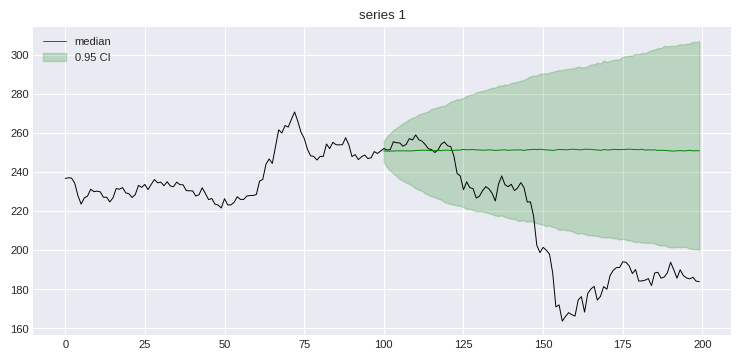

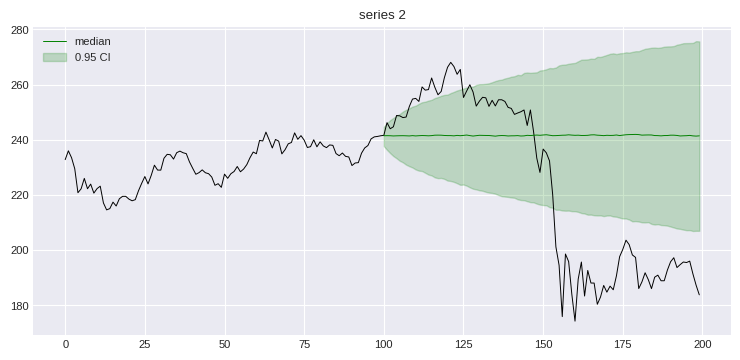

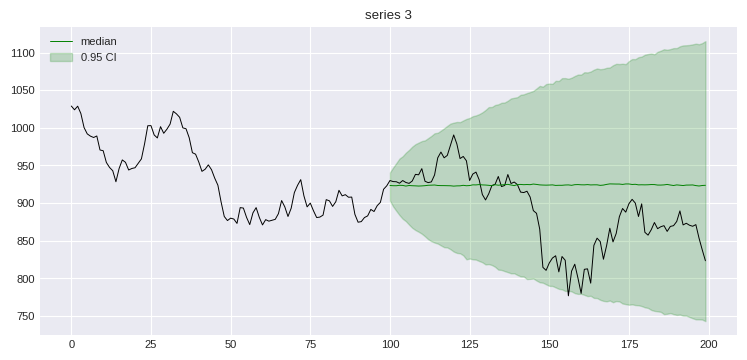

In [65]:
margin = 100
for i in range(x.shape[1]):
    fig,ax=plt.subplots(figsize=(9,4))
    ax.plot(x[train_sz-margin:train_sz+horiz,i], lw=0.7, c='k')
    
    x_hat = np.exp(samples[:,i,:])
    q025, q5, q955 = np.quantile(x_hat, [0.025, 0.5, 0.955], axis=-1)  
    xgrid = np.arange(margin, margin+horiz)
    
    ax.plot(xgrid, q5, lw=0.7, c='green', label='median')
    ax.fill_between(xgrid, q025, q955, color='green', alpha=0.2, label='0.95 CI')
    ax.set_title(f'series {i+1}')
    ax.legend(loc='upper left')

Here are the individual trajectories

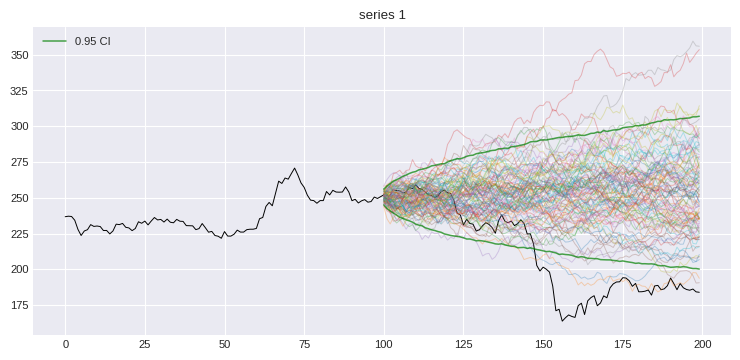

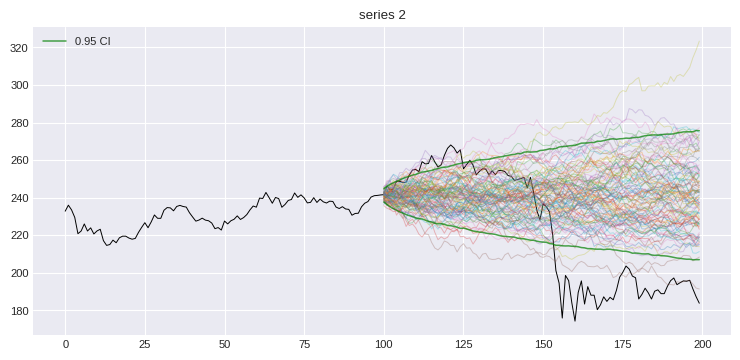

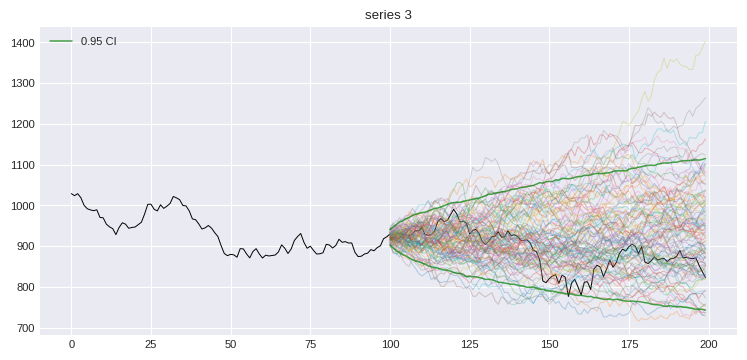

In [79]:
margin = 100
for i in range(x.shape[1]):
    fig,ax=plt.subplots(figsize=(9,4))
    ax.plot(x[train_sz-margin:train_sz+horiz,i], lw=0.7, c='k')
    
    x_hat = np.exp(samples[:,i,:])
    q025, q5, q955 = np.quantile(x_hat, [0.025, 0.5, 0.955], axis=-1)  
    xgrid = np.arange(margin, margin+horiz)
    
    ax.plot(xgrid, x_hat[:,::50], lw=0.7, alpha=0.3)
    ax.plot(xgrid, q025, lw=1.1, color='green', alpha=0.7, label='0.95 CI')
    ax.plot(xgrid, q955, lw=1.1, color='green', alpha=0.7)
    
    ax.set_title(f'series {i+1}')
    ax.legend(loc='upper left')

#### Checking against theory 

[[To the top]](#contents)

Below are the confidence intervals we get, when we use the same covariance estimate for all future steps (according to theory), superimposed on the condifednce intervals from recursive estimation. They should match 

In [107]:
covs2 = np.tile(covs[0], (horiz,1,1))
samples2 = sample_trajectory(x[train_sz-1], covs2, n_paths=5000)

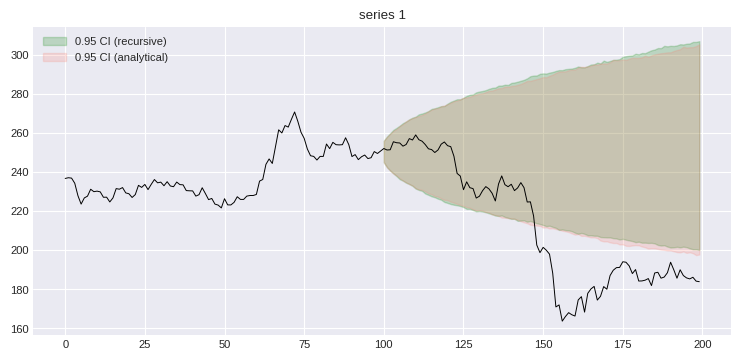

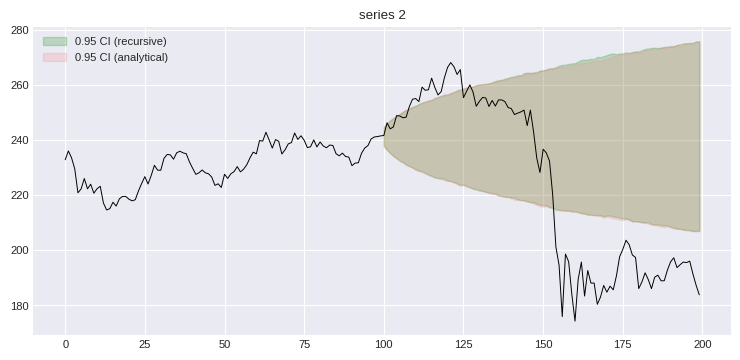

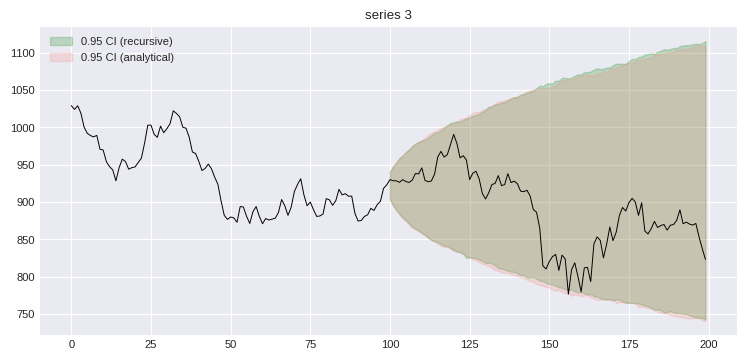

In [108]:
margin = 100
for i in range(x.shape[1]):
    fig,ax=plt.subplots(figsize=(9,4))
    ax.plot(x[train_sz-margin:train_sz+horiz,i], lw=0.7, c='k')
    
    x_hat = np.exp(samples[:,i,:])
    q025, q5, q955 = np.quantile(x_hat, [0.025, 0.5, 0.955], axis=-1)  

    x_hat2 = np.exp(samples2[:,i,:])
    q025_2, q5_2, q955_2 = np.quantile(x_hat2, [0.025, 0.5, 0.955], axis=-1)  
    
    xgrid = np.arange(margin, margin+horiz)
    
    ax.fill_between(xgrid, q025, q955, color='green', alpha=0.2, label='0.95 CI (recursive)')
    ax.fill_between(xgrid, q025_2, q955_2, color='salmon', alpha=0.2, label='0.95 CI (analytical)')
    
    ax.set_title(f'series {i+1}')
    ax.legend(loc='upper left')

#### Back to Risks
[[To the top]](#contents)


Now that we've estimated price changes, we can estimate value change of the portfolio
    
$V(t+\Delta t) - V(t)$.

Using first-order expansion  
    
$V(t+\Delta t) - V(t) \approx \frac{dV(t)}{dt} \Delta t$  
$ = \xi^T \frac{dS(t)}{dt} \Delta t$  
$ = \xi^T e^{p(t)} dp(t)$  
$ = \xi^T S(t) \circ dp(t)$  

where $p(t)$ is a vector of log prices, $dp(t)$ is log-price change (ie return), that we've estimated, $\circ$ is elementwise vector product. By assumption returns come from multivariate normal.  
  
Then variable $ L(t) = \xi^T S(t) \circ dp(t)$ would have expectation  
     
$E[\xi^T S(t) \circ dp(t)] = \xi^T S(t) \circ E[dp(t)] = 0$  
  
because we assume zero drift, and covariance  
  
$Cov[\xi^T S(t) \circ dp(t)] = E[(\xi^T S(t) \circ dp(t)) (\xi^T S(t) \circ dp(t))^T]$  
$= \xi^T S(t)S(t)^T E[dp(t) dp(t)^T] \xi$  
$= \xi^T S(t)S(t)^T Cov[dp(t)] \xi$  

Let's say portfolio allocation $\xi = [20, 100, 50]^T$. For one-day forecast we have:

In [130]:
xi = np.array([20, 100, 50])
s_t = x[train_sz-1]
loss_var = xi.T @ np.outer(s_t, s_t) @ covs[0] @ xi

In [111]:
from scipy.stats import norm

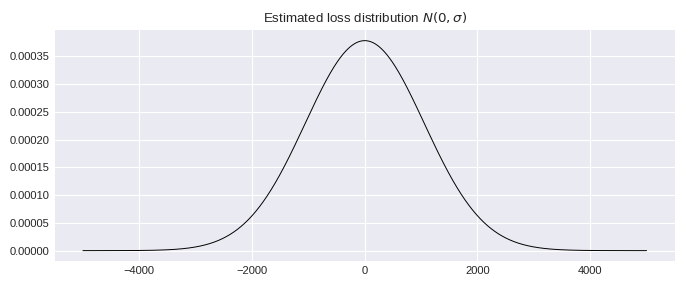

In [180]:
xgrid = np.linspace(-5000,5000,2000)
fig,ax=plt.subplots(figsize=(8,3))
ax.plot(xgrid, norm.pdf(xgrid, loc=0, scale=np.sqrt(loss_var)), lw=0.7, c='k')
ax.set_title('Estimated loss distribution $N(0, \sigma)$');

#### VAR
[[To the top]](#contents)  

Value under risk is just a quantile of loss distribution. 99th quantile in our case is 

In [144]:
print(f'{norm.ppf(0.99, loc=0, scale=np.sqrt(loss_var)) :.3f}')

2455.696


meaning, that the probability of incurring loss at least as extreme as 2456 is 0.01.  
  
Another common metric is *Expected shortfall*:  
  
$ES_{\alpha} = \frac{1}{1-\alpha} \int^{1}_{\alpha}F^{-1}(x)dx$  
  
where $F^{-1}$ is inverse CDF. Expected shortfall is a total loss (averaged by $1-\alpha$) we could get, which is at most as probable as $1-\alpha$. I don't know why it's called expected. It's not weigthed by probabilites, it's just averaged. Why not use plain expectation    
  
$\int^{\inf}_{F^{-1}(\alpha)}xf(x)dx$ ?  

#### Conclusion: does it all make sense?
[[To the top]](#contents)

  
Do the figures make sense?  
The standard deviation we've got appears huge

In [154]:
np.sqrt(loss_var)

1055.6015151582908

On the other hand the stock prices and the total value are sizeable too

In [155]:
s_t, s_t @ xi

(array([250.78, 241.45, 923.  ]), 75310.6)

Now, if we totally eyeball price change distributions based on their empirical deviations, then scale them up by their portfolio contributions, then sum them up (assuming independece), we get picture like this

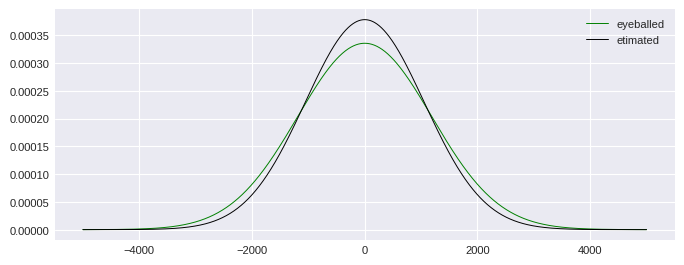

In [179]:
xgrid = np.linspace(-5000,5000,2000)
fig,ax=plt.subplots(figsize=(8,3))
scales = xi * np.std(x[1:train_sz] - x[:train_sz-1],axis=0)

ax.plot(xgrid, norm.pdf(xgrid, loc=0, scale=np.sum(scales)), lw=0.7, c='g', label='eyeballed')
ax.plot(xgrid, norm.pdf(xgrid, loc=0, scale=np.sqrt(loss_var)), lw=0.7, c='k', label='etimated')    
ax.legend();

In fact, so close as to put in question the point of estimating covariance matrix. Do we need it?  

Let's wrap both procedures in functions and compare them for different params.

In [178]:
def estimate_loss_scale(x, T, decay, xi):
    s_t = x[-1]
    cov = cov_predict(x, T, decay, 1)
    loss_var = xi.T @ np.outer(s_t, s_t) @ cov @ xi
    return np.sqrt(loss_var)

def eyeball_loss_scale(x, xi):
    return np.sum(xi * np.std(x[1:] - x[:-1],axis=0))

First, we will predict at different moments in time

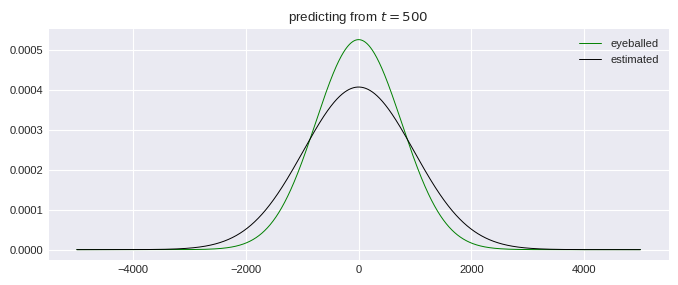

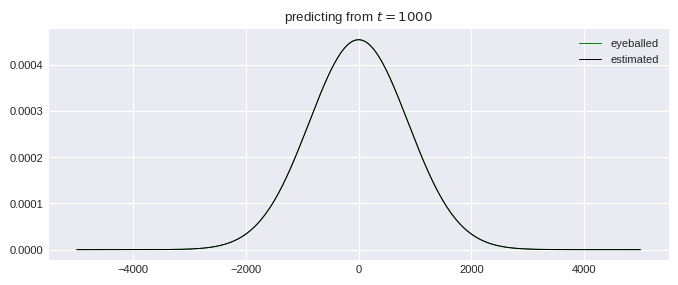

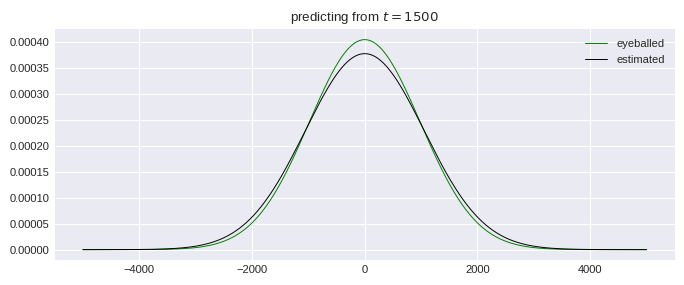

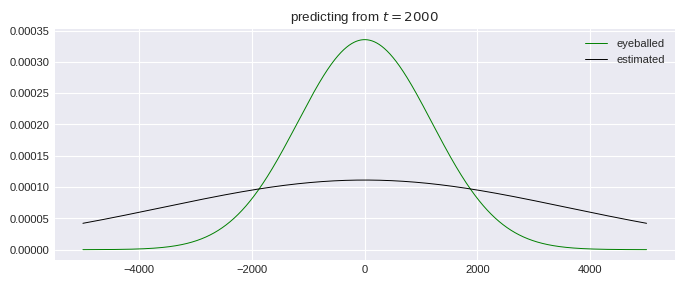

In [181]:
T        = 300
decay    = 0.94
xi       = np.array([20, 100, 50])
xgrid    = np.linspace(-5000,5000,2000)

for t in [500, 1000, 1500, 2000]:
    scale1 = estimate_loss_scale(x[:t], T, decay, xi)
    scale2 = eyeball_loss_scale(x[:t], xi)
    
    fig,ax=plt.subplots(figsize=(8,3))
    ax.plot(xgrid, norm.pdf(xgrid, loc=0, scale=scale2), lw=0.7, c='g', label='eyeballed')
    ax.plot(xgrid, norm.pdf(xgrid, loc=0, scale=scale1), lw=0.7, c='k', label='estimated')    
    ax.set_title(f'predicting from $t={t}$')
    ax.legend();

Clearly, the difference is present, especially for t=2000

In [188]:
cov_predict(x[:2000], T, decay, 1)

array([[[0.00059475, 0.00052972, 0.0001815 ],
        [0.00052972, 0.0007051 , 0.00019813],
        [0.0001815 , 0.00019813, 0.00026732]]])

In [189]:
cov_predict(x[:1000], T, decay, 1)

array([[[ 7.58324023e-05,  5.52662219e-05,  2.58890727e-05],
        [ 5.52662219e-05,  2.63664281e-04, -2.75161089e-05],
        [ 2.58890727e-05, -2.75161089e-05,  1.42131844e-04]]])

What stands out is that covariance is about 10 times bigger for t=2000. This makes sense: correlated prices would rush in the same direction, producing greater total swings

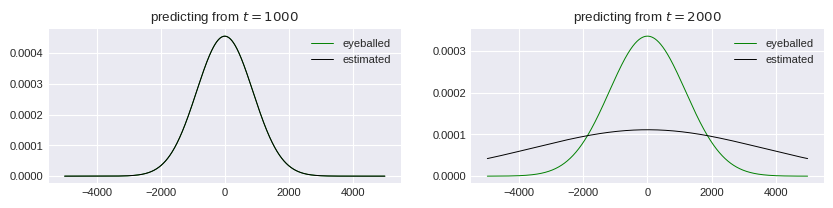

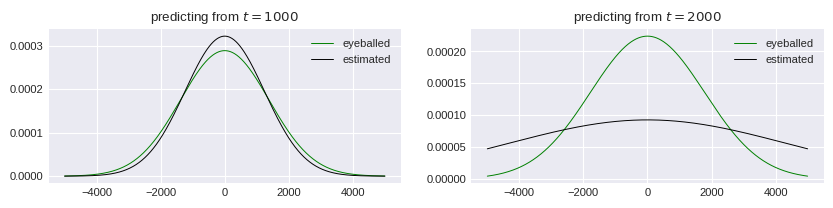

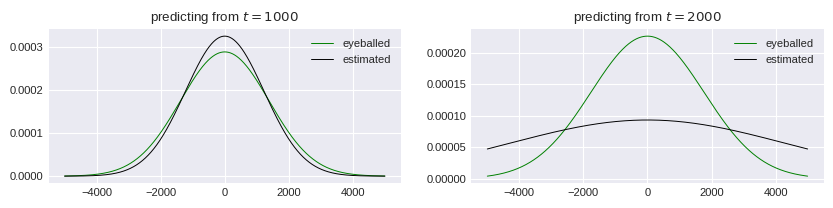

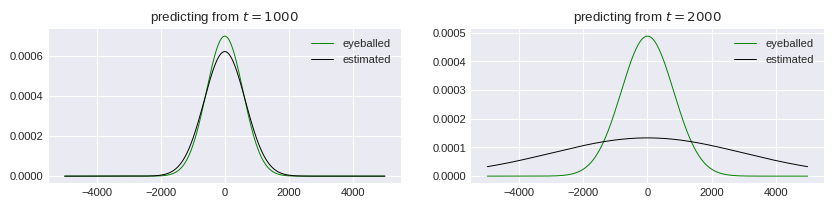

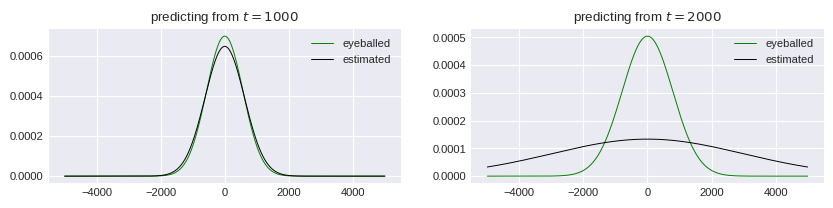

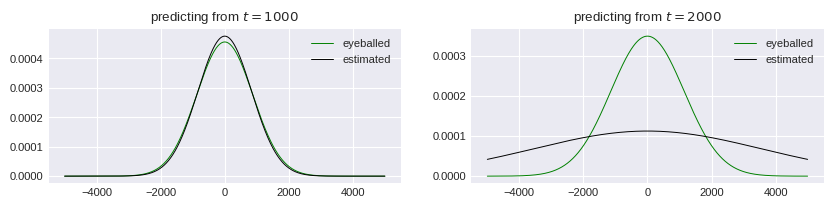

In [192]:
T        = 300
decay    = 0.94
xis      = np.array([[20, 100, 50],
                     [20, 50, 100],
                     [50, 20, 100],
                     [50, 100, 20],
                     [100, 50, 20],
                     [100, 20, 50]])
xgrid    = np.linspace(-5000,5000,2000)

for xi in xis:
    fig,ax=plt.subplots(1,2, figsize=(10,2)) 
    for i,t in enumerate([1000,2000]):
        scale1 = estimate_loss_scale(x[:t], T, decay, xi)
        scale2 = eyeball_loss_scale(x[:t], xi)
        
        ax[i].plot(xgrid, norm.pdf(xgrid, loc=0, scale=scale2), lw=0.7, c='g', label='eyeballed')
        ax[i].plot(xgrid, norm.pdf(xgrid, loc=0, scale=scale1), lw=0.7, c='k', label='estimated')    
        ax[i].set_title(f'predicting from $t={t}$')
        ax[i].legend();

#### Sources:
  
[1] Return to RiskMetrics: The Evolution of a Standard, Jorge Mina and Jerry Yi Xiao, 2001 RiskMetrics Group, Inc.  
[2] Quantitative Risk Management: Concepts, Techniques and Tools, Alexander J. McNeil, Rüdiger Frey, and Paul Embrechts, Princeton University Press, 2005